# CNN on CIFAR-10

In this notebook you need to put what you have learned into practice, and create your own convolutional classifier for the CIFAR-10 dataset.

The images in CIFAR-10 are RGB images (3 channels) with size 32x32 (so they have size 3x32x32). There are 10 different classes. See examples below.

![cifar10](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/cifar10.png?raw=1)


## Preliminaries

In [71]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn import metrics

sns.set_style("whitegrid")

def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def compute_confusion_matrix(target, pred, normalize=None):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(),
        pred.detach().cpu().numpy(),
        normalize=normalize
    )

def show_image(img):
    img = img.detach().cpu()
    img = img / 2 + 0.5   # unnormalize
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute((1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()

In [72]:
# The output of torchvision datasets are PIL images in the range [0, 1].
# We transform them to PyTorch tensors and rescale them to be in the range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # subtract 0.5 and divide by 0.5
    ]
)

batch_size = 64  # both for training and testing

# Load datasets
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

# Map from class index to class name.
classes = {index: name for name, index in train_set.class_to_idx.items()}

Files already downloaded and verified
Files already downloaded and verified


In [73]:
print("Training data")
print("Number of points:", len(train_set))
x, y = next(iter(train_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(train_set.targets))} (unique labels: {set(train_set.targets)})")

print("\nTest data")
print("Number of points:", len(test_set))
x, y = next(iter(test_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(test_set.targets))} (unique labels: {set(test_set.targets)})")

n_classes = len(set(test_set.targets))

Training data
Number of points: 50000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

Test data
Number of points: 10000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})


### Show example images

Run multiple times to see different examples.

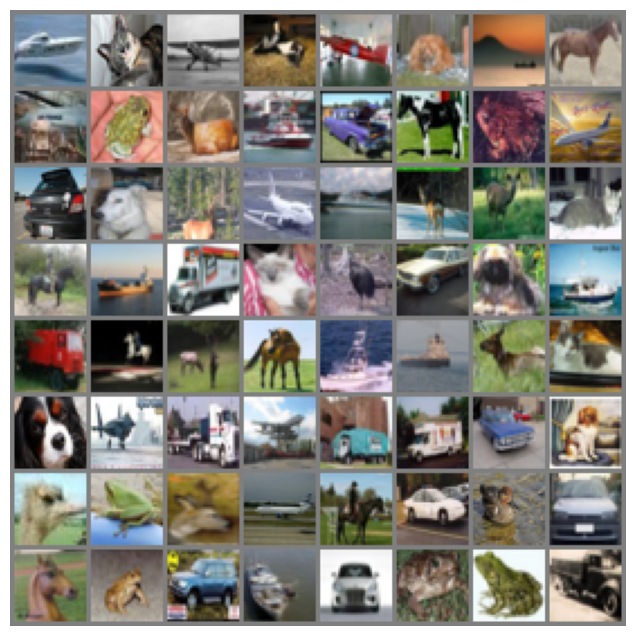

In [74]:
# Get random training images and show them.
images, labels = next(iter(train_loader))
show_image(torchvision.utils.make_grid(images))

## Define a convolutional neural network


**Assignment 1:** Define a convolutional neural network.
You may use the code from previous notebooks.
We suggest that you start with a small network, and make sure that everything is working.
Once you can train successfully, come back and improve the architecture.

In [87]:
class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first pass."""

    first = True

    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x


class Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        # Convolutional layer: 3 input channels (RGB), 32 output channels, 3x3 kernel
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=4, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels= 24, kernel_size=3, stride=1, padding=1)

        # Fully connected layers
        self.fc1 = nn.Linear(24 * 7 * 7, 128)  # Hidden layer
        self.fc2 = nn.Linear(128, num_classes)  # Output layer, assuming 10 classes

    def forward(self, x):
        # Convolutional layer 1 with ReLU activation
        x = F.relu(self.conv1(x))

        # Max pooling
        x = F.max_pool2d(x, 2)

        # Convolutional layer 2 with ReLU activation
        x = F.relu(self.conv2(x))

        # Optional: Add another max pooling after conv2
        x = F.max_pool2d(x, 2)

        # Adjust the flatten operation for the tensor dimensions post conv2 and pooling.
        # If pooling is applied again, the spatial dimensions would be halved once more from 16x16 to 8x8.
        x = x.view(-1, 24 * 7 * 7)

        # Hidden fully connected layer with ReLU activation
        x = F.relu(self.fc1(x))

        # Output fully connected layer
        x = self.fc2(x)

        return x

class ModelXX(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=4, stride=1, padding=1)

        # Ensuring the output channels of conv2 are equal to num_classes
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=num_classes, kernel_size=3, stride=1, padding=1)

        # This layer will reduce the spatial dimensions to 1x1
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        # Conv1 + ReLU + Pooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)

        # Conv2 + ReLU + Pooling
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        # Convert spatial dimensions to 1x1. This acts similar to a FC layer.
        x = self.global_avg_pool(x)

        # Flatten the tensor so it's shape is [batch_size, num_classes]
        x = x.view(x.size(0), -1)

        return x


model = Model(n_classes)
device = torch.device('cuda')  # use cuda or cpu
model.to(device)
print(model)

Model(
  (conv1): Conv2d(3, 12, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1176, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


## Define a loss function and optimizer

**Assignment 2:** Define the loss function and optimizer.
You might need to experiment a bit with the learning rate.

In [88]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


## Train the network

**Assignment 3:** Finish the training loop below.
Start by using a small number of epochs (e.g. 2).
Even with a low number of epochs you should be able to see results that are better than chance.
When everything is working increase the number of epochs to find out how good your network really is.

In [89]:
# Test the forward pass with dummy data
out = model(torch.randn(2, 3, 32, 32, device=device))
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().cpu().numpy()}")
print(f"Output probabilities:\n{out.softmax(1).detach().cpu().numpy()}")

Output shape: torch.Size([2, 10])
Output logits:
[[-0.08785194 -0.07777382  0.00984305  0.01266074  0.08843643 -0.11501036
  -0.0427043  -0.02657607  0.01219207 -0.13455698]
 [-0.06978613 -0.06307209  0.0532305   0.04716432  0.11222922 -0.06101171
  -0.00062215  0.04306633 -0.00643922 -0.05062027]]
Output probabilities:
[[0.09475578 0.09571557 0.10448024 0.10477504 0.11302299 0.09221699
  0.09913182 0.10074361 0.10472595 0.09043197]
 [0.09305809 0.09368499 0.1052397  0.10460322 0.11163553 0.09387822
  0.09972218 0.10417544 0.09914377 0.09485884]]


In [ ]:
batch_size = 64
num_epochs = 15
validation_every_steps = 500

step = 0
model.train()

train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):

    train_accuracies_batches = []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass, compute gradients, perform one training step.

        # Forward pass to compute predictions.
        output = model(inputs)

        # Compute the loss.
        loss = loss_fn(output, targets)

        # Zero out any gradients from the previous iteration.
        optimizer.zero_grad()

        # Back-propagate the error.
        loss.backward()

        # Update the model's parameters.
        optimizer.step()


        # Increment step counter
        step += 1

        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))

        if step % validation_every_steps == 0:

            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))

            train_accuracies_batches = []

            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                model.train()

            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))

            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {valid_accuracies[-1]}")

print("Finished training.")

Step 500     training accuracy: 0.4255625
             test accuracy: 0.5213
Step 1000    training accuracy: 0.5692373853211009
             test accuracy: 0.589
Step 1500    training accuracy: 0.6005
             test accuracy: 0.6107
Step 2000    training accuracy: 0.6478282683486238
             test accuracy: 0.6416
Step 2500    training accuracy: 0.6793831168831169
             test accuracy: 0.6418
Step 3000    training accuracy: 0.68753125
             test accuracy: 0.6644
Step 3500    training accuracy: 0.7131636424731183
             test accuracy: 0.67
Step 4000    training accuracy: 0.7376736111111111
             test accuracy: 0.6823
Step 4500    training accuracy: 0.73296875
             test accuracy: 0.6824
Step 5000    training accuracy: 0.7570515422077922
             test accuracy: 0.6888
Step 5500    training accuracy: 0.7950721153846154
             test accuracy: 0.6988
Step 6000    training accuracy: 0.77065625
             test accuracy: 0.6986
Step 6500    tra

## Test the network

Now we show a batch of test images and generate a table below with the true and predicted class for each of these images.

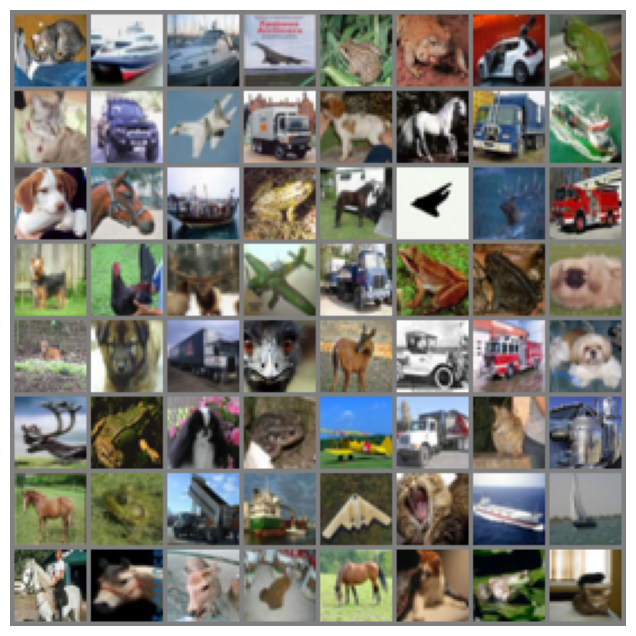

    TRUE        PREDICTED
-----------------------------
     cat          bird     
    ship          ship     
    ship          ship     
  airplane      airplane   
    frog          deer     
    frog          frog     
 automobile    automobile  
    frog          bird     
     cat          deer     
 automobile    automobile  
  airplane      airplane   
    truck         truck    
     dog           dog     
    horse         horse    
    truck         truck    
    ship          ship     
     dog           dog     
    horse         horse    
    ship          ship     
    frog          frog     
    horse          cat     
  airplane        bird     
    deer          bird     
    truck         truck    
     dog           dog     
    bird          bird     
    deer          deer     
  airplane      airplane   
    truck         truck    
    frog          frog     
    frog          frog     
     dog           dog     
    deer          bird     
     dog           d

In [65]:
inputs, targets = next(iter(test_loader))
inputs, targets = inputs.to(device), targets.to(device)
show_image(make_grid(inputs))
plt.show()

outputs = model(inputs)
_, predicted = torch.max(outputs.data, 1)

print("    TRUE        PREDICTED")
print("-----------------------------")
for target, pred in zip(targets, predicted):
    print(f"{classes[target.item()]:^13} {classes[pred.item()]:^13}")


We now evaluate the network as above, but on the entire test set.

In [66]:
# Evaluate test set
confusion_matrix = np.zeros((n_classes, n_classes))
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))

        confusion_matrix += compute_confusion_matrix(targets, predictions)

    test_accuracy = np.sum(test_accuracies) / len(test_set)

    model.train()


Here we report the **average test accuracy** (number of correct predictions divided by test set size).

In [67]:
print(f"Test accuracy: {test_accuracy:.3f}")

Test accuracy: 0.679


Here we look a bit more in depth into the performance of the classifier, using the **confusion matrix**. The entry at the i-th row and j-th column indicates the number of samples with true label being the i-th class and predicted label being the j-th class.

We normalize the rows: given all examples of a specific class (row), we can observe here how they are classified by our model. Ideally, we would like the entries on the diagonals to be 1, and everything else 0. This would mean that all examples from that class are classified correctly.

The classes that are harder to classify for our model have lower numbers on the diagonal. We can then see exactly *how* they are misclassified by looking at the rest of the row.


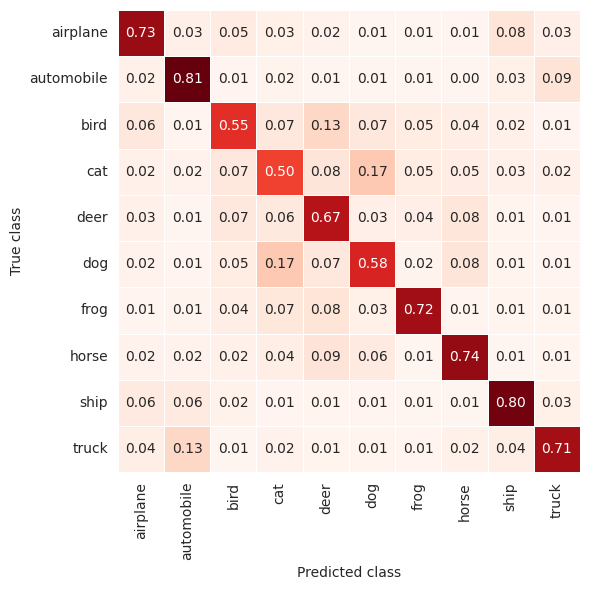

In [68]:
def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

x_labels = [classes[i] for i in classes]
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()

Here we focus on the diagonal and plot the numbers in a bar plot. This gives us a clearer picture of the accuracy of the model for different classes.

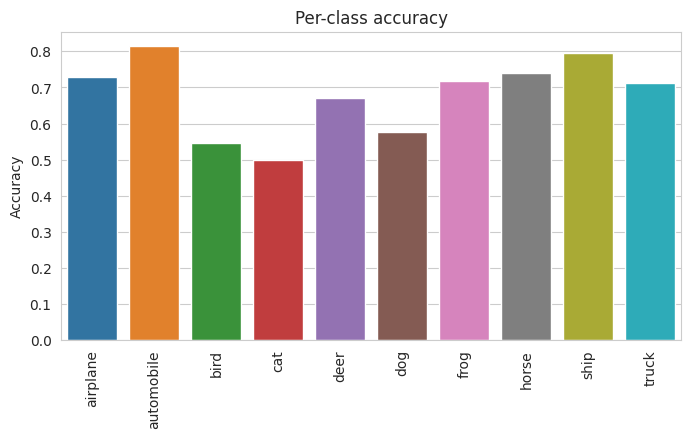

In [69]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=x_labels, y=np.diag(normalize(confusion_matrix, 'true')))
    plt.xticks(rotation=90)
    plt.title("Per-class accuracy")
    plt.ylabel("Accuracy")
    plt.show()

**Assignment 4:**
1. Go back and improve performance of the network. By using enough convolutional layers with enough channels (and by training for long enough), you should easily be able to get a test accuracy above 60%, but see how much further you can get it! Can you reach 70%?

2. Briefly describe what you did and any experiments you did along the way as well as what results you obtained.
Did anything surprise you during the exercise?
What were the changes that seemed to improve performance the most?


  1) My first network performed quite well allready at 55 percent with 2 epoches, than i tried 30 and got to 63%, but it got worse later in the training because of overfitting so i will try some regularization to see if i can get acuracy up. That did not give many any results. I only chekced by hand for some values, but performed well for small regularization.

  2) I only have one convolutional layer so far so lets play around have more, ... we could also you cross validation for parameters we use here, maybe a bit of an overkill i guess. I added a second layer that worked well and got me to 68 %with changinf kernal size. Still have the Problem with overfitting in the end.

3. Write down key lessons/insights you got during this exercise.

  My One key takeaway is that in trainig that you training accuracy does not go up too high and you overfit. There are a lot of possibilities how to change that, but it takes too long to chekc one vlaue after the other by hand so we should use some validation methods
**Answer:**

# Training on GPU

**Optional Assignment:**
If you have a GPU, we suggest that you try training your model on GPU. For this, you need to move the model to GPU after defining it, which will recursively go over all modules and convert their parameters and buffers to CUDA tensors. You also need to transfer both the inputs and targets to GPU at each training step, before performing the forward pass.

The code for this is already in place: notice the `.to(device)` statements. The only thing left to do is change the definition of `device` from `'cpu'` to `'cuda'`.

If you don't have a GPU, you can do this on [Google Colab](https://research.google.com/colaboratory/).

Use the code below to check if any GPU is avaiable in your current setup. This should print the models of all available GPUs.


In [70]:
# Check if we have GPUs available
print("Available CUDA devices:", [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())])

Available CUDA devices: ['Tesla T4']


You may not notice any significant speed-up from using a GPU. This is probably because your network is really small. Try increasing the width of your network (number of channels in the convolutional layers) and see if you observe any speed-up on GPU compared to CPU.

# Exercise from Michael Nielsen's book

**Assignment 5:** Pick an exercise of your own choice from [Michael Nielsen's book](http://neuralnetworksanddeeplearning.com/).

Question: What classification accuracy do you get if you omit the fully-connected layer, and just use the convolutional-pooling layer and softmax layer? Does the inclusion of the fully-connected layer help?

For this we will just use the network we have defined in this notebook already and jsut change it so we dont have a fully connected layerfor this we changed the code in the Model Class to the following:


    class Model(nn.Module):
        def __init__(self, num_classes):
            super().__init__()
            self.num_classes = num_classes
            
            # Convolutional layers
            self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=4, stride=1, padding=1)
            
            # Ensuring the output channels of conv2 are equal to num_classes
            self.conv2 = nn.Conv2d(in_channels=12, out_channels=num_classes, kernel_size=3, stride=1, padding=1)

            # This layer will reduce the spatial dimensions to 1x1
            self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        def forward(self, x):
            # Conv1 + ReLU + Pooling
            x = F.relu(self.conv1(x))
            x = F.max_pool2d(x, 2)
            
            # Conv2 + ReLU + Pooling
            x = F.relu(self.conv2(x))
            x = F.max_pool2d(x, 2)

            # Convert spatial dimensions to 1x1. This acts similar to a FC layer.
            x = self.global_avg_pool(x)

            # Flatten the tensor so it's shape is [batch_size, num_classes]
            x = x.view(x.size(0), -1)

            return x



The results are the following: When changing to this we get training accuracy of 40 percent, so lets say it how it is horrible accuracy. THe question is why ? Convolutional operation are good in detecting small features of a picture, but dont get the overall features of the image, for that we use the fully connected network.